# Notebook to visualize simulated Alpine-3D grids
## First, import packages

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import glob
import urllib.request
import moviepy.editor as mpy
from palettable.colorbrewer.sequential import *
from palettable.colorbrewer.diverging import *

## Download file from dropbox and plot

--2020-07-08 16:16:55--  https://www.dropbox.com/s/l035enj35bsxsd6/a3d_grids.nc?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/l035enj35bsxsd6/a3d_grids.nc [following]
--2020-07-08 16:16:56--  https://www.dropbox.com/s/raw/l035enj35bsxsd6/a3d_grids.nc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaedd85fac25ffc7c9921528452.dl.dropboxusercontent.com/cd/0/inline/A7JHJvuMTqoxlJ5NjkZa_f9_2_hlOVs_54a93-_GjYaCJqdlPCq8e9G-tCw_GUeMK8vLRo3vE3MOWUvl12bGH0TbtF4ng8NLXAlgWUtn4SyYNwi-phewUd9ca0yuUV8s8a8/file# [following]
--2020-07-08 16:16:56--  https://ucaedd85fac25ffc7c9921528452.dl.dropboxusercontent.com/cd/0/inline/A7JHJvuMTqoxlJ5NjkZa_f9_2_hlOVs_54a93-_GjYaCJqdlPCq8e9G-tCw_GUeMK8vLRo3vE3MOWUvl12bGH0TbtF4ng8NLXAlgWUtn4SyYN

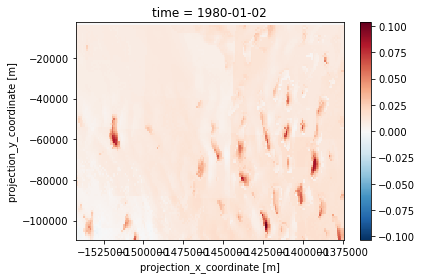

In [2]:
!wget -O a3d_grids.nc https://www.dropbox.com/s/l035enj35bsxsd6/a3d_grids.nc?dl=0
file_name="a3d_grids.nc"
ds = xr.open_dataset(file_name)
SMB = ds['pr'] - ds['SFC_SUBL'] - ds['MS_SNOWPACK_RUNOFF']
SMB = SMB.cumsum(dim='time')
SMB[-1,:,:].plot()

## Add netCDF file path, define grid variable to plot, and time step.

In [3]:
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)
tgt_time = "1980-01-01T12:00:00" # Specific timestep
tgt_time_ind = -1 # Last timestep

'''
Surface Mass Balance:
Precip - sublimation - runoff - net wind erosion
Precip units: kg/m2/s
time step = 12 hours = 60 * 60 * 12 seconds = 43200 seconds
'''
time_step = 60 * 60 * 12 # seconds
SMB = ds['pr'] * time_step - ds['SFC_SUBL'] - ds['MS_SNOWPACK_RUNOFF'] # Does this includ wind erosion???
SMB = SMB.cumsum(dim='time')
SMB

<xarray.DataArray (time: 1, northing: 107, easting: 168)>
array([[[ 8.523356 ,  6.672721 ,  5.5403137, ..., 73.66186  ,
         70.910446 , 48.298283 ],
        [ 8.516814 ,  6.4711103,  4.0915585, ..., 71.2206   ,
         63.447887 , 45.41784  ],
        [ 8.514674 ,  4.6757817,  5.146557 , ..., 66.12955  ,
         53.662292 , 41.56237  ],
        ...,
        [10.692512 ,  8.950523 ,  8.976767 , ..., 10.509863 ,
         11.189064 , 11.508143 ],
        [10.715304 ,  9.13993  ,  8.560611 , ..., 10.134004 ,
         11.109069 , 11.6110325],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T12:00:00
  * northing  (northing) float32 -109000.0 -108000.0 ... -4000.0 -3000.0
  * easting   (easting) float32 -1542000.0 -1541000.0 ... -1376000.0 -1375000.0

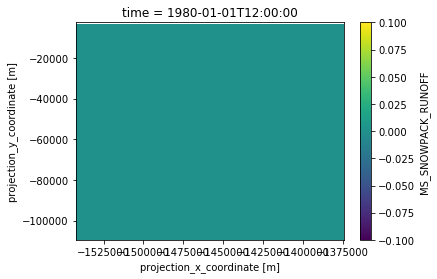

In [4]:
# tmp = time_step * ds['pr'][0,:,:]
# tmp = time_step * ds['SFC_SUBL'][0,:,:]
tmp = time_step * ds['MS_SNOWPACK_RUNOFF'][0,:,:]
tmp.plot()

## Load coastlines data

In [5]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

## Plot grid

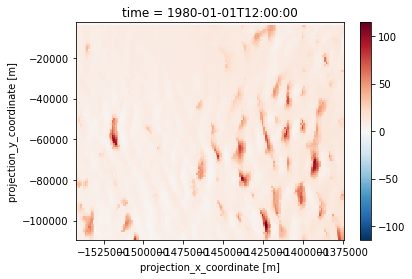

In [6]:
# Plot on specific day
# ds.sel(time=tgt_time)[var_plot].plot()

# Plot last timestep
SMB.isel(time=tgt_time_ind).plot()

## Plot map

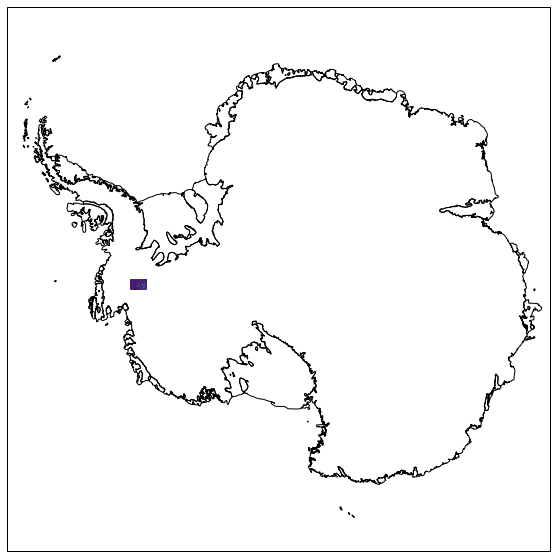

In [7]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree()) # Full ice sheet
# axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Define easting and northings
northings = ds.sel(time=tgt_time)['northing']
eastings = ds.sel(time=tgt_time)['easting']

# Plot map
mesh = plt.pcolormesh(eastings, northings, SMB.isel(time=tgt_time_ind))

# Make a movie of SWE and SMB

In [8]:
# # Settings
# var = 'swe'
# fps = 30
# file_name = "movie"

# # Clear old images, gifs, and movies
# !mkdir -p movie_frame
# !rm -f movie.gif
# !rm -f movie.mp4

# # Calculate colorbar limits
# diff_magnitude = np.abs(ds[var] - ds.isel(time=0)[var])
# diff_lim = diff_magnitude.max()
# lim = ds[var].max()

# for j in range(0, len(ds['time']), 2):
# # for j in range(0, 2):
    
#     # Figure settings
#     fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
#     time = str(ds['time'][j].values)
    
#     # SWE
#     swe = ax1.pcolormesh(eastings/1000, northings/1000, ds.isel(time=j)[var], \
#                          cmap=Blues_9.mpl_colormap, vmin=0, vmax=lim)
#     fig1.colorbar(swe, ax=ax1)
#     ax1.set_title("SWE [mm]: " + time[0:10])
    
#     # Change in SWE
#     dswe = ax2.pcolormesh(eastings/1000, northings/1000, \
#                           ds.isel(time=j)[var] - ds.isel(time=0)[var], \
#                           cmap=RdBu_11.mpl_colormap, \
#                           vmin=-diff_lim, vmax=diff_lim)
    
#     fig1.colorbar(dswe, ax=ax2)
#     ax2.set_title("Accumulated SMB [mm]: " + time[0:10])
    
#     #Save Figure with image number zero padding 
#     if j < 10:
#         plt.savefig("movie_frame/frame_00" + str(j) + ".png", dpi=100)
#     elif j < 100 and j > 9:
#         plt.savefig("movie_frame/frame_0" + str(j) + ".png", dpi=100)
#     else:
#         plt.savefig("movie_frame/frame_" + str(j) + ".png", dpi=100)
#     plt.close()
    
# # Make a .mp4 movie and gif
# file_list = sorted(glob.glob('movie_frame/*.png'))
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_videofile(file_name+'.mp4')
# clip.write_gif(file_name+'.gif')

# # Clear images
# !rm -rf movie_frame

## Plot timeseries of integrated SMB

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([214692.03, 214692.12, 214692.23, 214692.33, 214692.44, 214692.53,
        214692.62, 214692.73, 214692.83, 214692.94, 214693.03],
       dtype=float32),
 <a list of 10 Patch objects>)

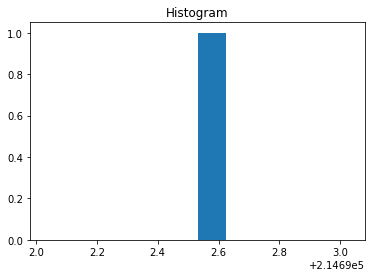

In [9]:
SMB_t = SMB.sum(dim='northing').sum(dim='easting')
SMB_t.plot()

In [12]:
SMB

<xarray.DataArray (time: 1, northing: 107, easting: 168)>
array([[[ 8.523356 ,  6.672721 ,  5.5403137, ..., 73.66186  ,
         70.910446 , 48.298283 ],
        [ 8.516814 ,  6.4711103,  4.0915585, ..., 71.2206   ,
         63.447887 , 45.41784  ],
        [ 8.514674 ,  4.6757817,  5.146557 , ..., 66.12955  ,
         53.662292 , 41.56237  ],
        ...,
        [10.692512 ,  8.950523 ,  8.976767 , ..., 10.509863 ,
         11.189064 , 11.508143 ],
        [10.715304 ,  9.13993  ,  8.560611 , ..., 10.134004 ,
         11.109069 , 11.6110325],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T12:00:00
  * northing  (northing) float32 -109000.0 -108000.0 ... -4000.0 -3000.0
  * easting   (easting) float32 -1542000.0 -1541000.0 ... -1376000.0 -1375000.0